In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
from einops import rearrange
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

### Annotations file exploration

In [2]:
TRAIN_CSV = 'EPIC_100_train.csv'
VAL_CSV = 'EPIC_100_validation.csv'

### Train df

In [3]:
df = pd.read_csv(TRAIN_CSV)
df.head(5)

,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01_01_0,P01,P01_01,00:00:01.089,00:00:00.14,00:00:03.37,8,202,open door,open,3,door,3,['door'],[3]
1,P01_01_1,P01,P01_01,00:00:02.629,00:00:04.37,00:00:06.17,262,370,turn on light,turn-on,6,light,114,['light'],[114]
2,P01_01_10,P01,P01_01,00:00:23.340,00:00:24.97,00:00:26.20,1498,1572,open drawer,open,3,drawer,8,['drawer'],[8]
3,P01_01_100,P01,P01_01,00:07:57.919,00:07:59.75,00:08:00.88,28785,28852,take cup,take,0,cup,13,['cup'],[13]
4,P01_01_101,P01,P01_01,00:08:00.020,00:08:01.47,00:08:02.21,28888,28932,open cupboard,open,3,cupboard,3,['cupboard'],[3]


In [4]:
df.shape

(67217, 15)

In [7]:
df['verb'][df['verb_class']==1].head(1)

7    put-on
Name: verb, dtype: object

In [5]:
df_1 = df[df['verb_class']==3]
df_1.head(1)

,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01_01_0,P01,P01_01,00:00:01.089,00:00:00.14,00:00:03.37,8,202,open door,open,3,door,3,['door'],[3]


In [6]:
df['verb_class'].unique()

array([ 3,  6,  0,  5,  1,  4, 10,  7, 59, 77, 13, 23,  9, 38, 17, 28, 12,
        2, 72, 16, 35, 60,  8, 37, 18, 14, 11, 20, 39, 31, 15, 41, 22, 45,
       24, 42, 19, 34, 51, 27, 53, 52, 48, 47, 87, 64, 71, 49, 32, 21, 33,
       56, 44, 73, 25, 63, 30, 36, 82, 67, 26, 50, 89, 46, 61, 70, 76, 68,
       74, 40, 55, 86, 43, 91, 57, 66, 83, 94, 81, 29, 65, 58, 78, 62, 95,
       54, 85, 88, 69, 75, 79, 84, 80, 92, 96, 90, 93], dtype=int64)

In [7]:
df['verb_class'].value_counts()

verb_class
0     14848
1     12225
2      6927
3      4870
4      3483
      ...  
94        3
95        2
96        2
90        2
93        1
Name: count, Length: 97, dtype: int64

<Axes: title={'center': 'Training labels'}, xlabel='Label', ylabel='Frequency'>

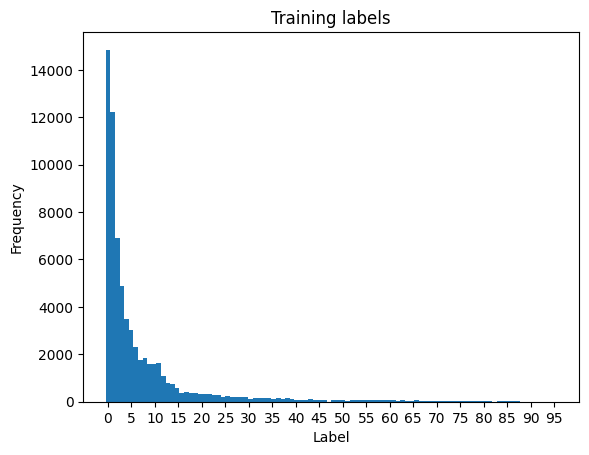

In [8]:
df['verb_class'].plot(kind='hist', bins=98, title='Training labels', xticks=[5*x for x in range(20)], xlabel='Label', align='left')

In [9]:
columns = ['participant_id', 'video_id', 'start_frame', 'stop_frame', 'verb_class']
clip_df = df[columns]
clip_df.head()

,participant_id,video_id,start_frame,stop_frame,verb_class
0,P01,P01_01,8,202,3
1,P01,P01_01,262,370,6
2,P01,P01_01,1498,1572,3
3,P01,P01_01,28785,28852,0
4,P01,P01_01,28888,28932,3


In [10]:
clip_df['num_frames'] = clip_df.apply(lambda row: row.stop_frame - row.start_frame, axis = 1)

C:\Users\34609\AppData\Local\Temp\ipykernel_7816\265523361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clip_df['num_frames'] = clip_df.apply(lambda row: row.stop_frame - row.start_frame, axis = 1)


In [11]:
clip_df.head()

,participant_id,video_id,start_frame,stop_frame,verb_class,num_frames
0,P01,P01_01,8,202,3,194
1,P01,P01_01,262,370,6,108
2,P01,P01_01,1498,1572,3,74
3,P01,P01_01,28785,28852,0,67
4,P01,P01_01,28888,28932,3,44


In [12]:
a = clip_df['num_frames']

In [13]:
a_arr = np.array(a)
a_arr

array([194, 108,  74, ..., 461, 181, 390], dtype=int64)

(array([15285., 22597.,  9644.,  5283.,  3147.,  2187.,  1607.,  1311.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <BarContainer object of 8 artists>)

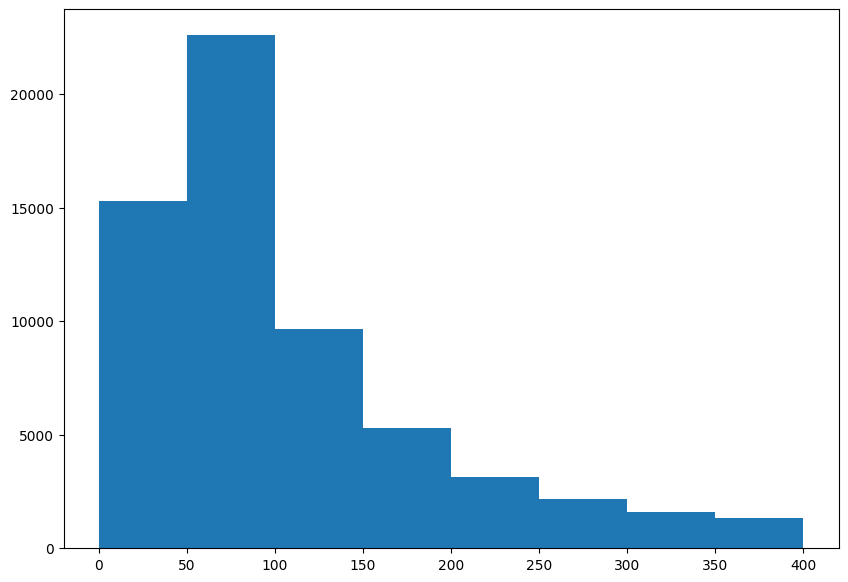

In [14]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a_arr, bins = [0, 50, 100, 150, 200, 250, 300, 350, 400])

In [15]:
b = [x for x in a_arr if x > 200]
print(f'Total of clips with more than 200 frames: {len(b)}')
print(f'% of frames with more than 200 frames: {(len(b)/len(a)) * 100}')

Total of clips with more than 200 frames: 14329
% of frames with more than 200 frames: 21.317523840695063


In [16]:
df_drop = clip_df.drop(clip_df[clip_df['video_id']== 'P23_04'].index)

In [17]:
# df_drop['video_id'].unique()

In [18]:
clip_info = clip_df.iloc[0]
clip_info

participant_id       P01
video_id          P01_01
start_frame            8
stop_frame           202
verb_class             3
num_frames           194
Name: 0, dtype: object

In [19]:
clip_df['participant_id'].unique()

array(['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09',
       'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P19',
       'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28',
       'P29', 'P30', 'P31', 'P35', 'P37'], dtype=object)

In [20]:
error = clip_df[clip_df['video_id'] == 'P23_04']

In [21]:
print(error)

      participant_id video_id  start_frame  stop_frame  verb_class  num_frames
46123            P23   P23_04            1         580           0         579
46124            P23   P23_04          586        1816          12        1230
46125            P23   P23_04        15381       15867          12         486
46126            P23   P23_04        82392       82725           2         333
46127            P23   P23_04        82764       83062          12         298
...              ...      ...          ...         ...         ...         ...
46306            P23   P23_04        79679       79736           0          57
46307            P23   P23_04        79736       79788           5          52
46308            P23   P23_04        79914       79983           0          69
46309            P23   P23_04        80019       80485           2         466
46310            P23   P23_04        80922       81630           2         708

[188 rows x 6 columns]


In [22]:
df_drop.shape

(67029, 6)

#### Dataset class testing

In [23]:
middel_frame = clip_info['start_frame'] + (clip_info['stop_frame'] - clip_info['start_frame']) // 2
clip_frames = (middel_frame - 30 // 2, middel_frame + 30 // 2)
clip_paths = ['home/' + 'frame_' + str(x).rjust(10, '0') + '.jpg' for x in range(clip_frames[0], clip_frames[1])]

In [24]:
for path in clip_paths:
    print(path)
    break

home/frame_0000000090.jpg


In [25]:
x = torch.rand((1920, 1080, 3)).unsqueeze(-1)
y = torch.rand((1920, 1080, 3)).unsqueeze(-1)
z = torch.rand((1920, 1080, 3)).unsqueeze(-1)

print(x.shape)

torch.Size([1920, 1080, 3, 1])


In [26]:
lst = [x, y, z]
v = torch.cat(lst, -1)
print(v.shape)

torch.Size([1920, 1080, 3, 3])


In [27]:
x = torch.rand((640, 640, 3))
x
resize = T.Resize(size=(224,224))
x_resized = resize(x)
print(x_resized.shape)

torch.Size([640, 224, 224])


In [28]:
missing_frames = 7

# check if missing frames is odd in order to ensure that after padding, 
# num_frames equals NUM_FRAMES
if missing_frames % 2 == 0:
    print('1')
    pad = (missing_frames // 2, missing_frames // 2)
else:
    print('2')
    pad = (missing_frames // 2 + 1, missing_frames // 2)
print(f'pad: {pad}')
video = F.pad(v, pad, 'constant', 0)
print(video.shape)

2
pad: (4, 3)
torch.Size([1920, 1080, 3, 10])


In [29]:
# pool of size=3, stride=2
v1 = rearrange(video, 'c w h t -> c (w h) t')
print(f'v1 shape: {v1.shape}')
total = 10
num = 3
s = (total - 1)//(num - 1)
print(f'stride: {s}')
m = torch.nn.MaxPool1d(kernel_size = 2, stride=s)
output = m(v1)
output = rearrange(output, 'c (w h) t -> c w h t', h = 1080)
print(output.shape)

v1 shape: torch.Size([1920, 3240, 10])
stride: 4
torch.Size([1920, 3, 1080, 3])


In [30]:
a = 1920 * 1080
a

2073600

### Test df

In [31]:
test_df = pd.read_csv(VAL_CSV)

In [32]:
test_df.head(5)

,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01_11_0,P01,P01_11,00:00:00.560,00:00:00.00,00:00:01.89,1,113,take plate,take,0,plate,2,['plate'],[2]
1,P01_11_1,P01,P01_11,00:00:01.700,00:00:01.56,00:00:02.45,93,147,put down plate,put-down,1,plate,2,['plate'],[2]
2,P01_11_10,P01,P01_11,00:00:48.500,00:00:49.15,00:00:50.95,2949,3057,take paper,take,0,paper,49,['paper'],[49]
3,P01_11_100,P01,P01_11,00:05:27.840,00:05:27.28,00:05:31.97,19636,19918,wash cloth,wash,2,cloth,17,['cloth'],[17]
4,P01_11_101,P01,P01_11,00:05:26.840,00:05:27.37,00:05:29.86,19642,19791,take cloth,take,0,cloth,17,['cloth'],[17]


In [33]:
test_df.shape

(9668, 15)

In [34]:
test_df['verb_class'].unique()

array([ 0,  1,  2, 18,  6,  3,  8, 13,  4, 14, 41, 36, 12,  5, 28,  7, 31,
       39, 15,  9, 60, 11, 33, 10, 17, 49, 43, 35, 24, 37, 42, 48, 20, 34,
       51, 27, 47, 16, 46, 21, 53, 68, 26, 65, 69, 25, 38, 19, 75, 84, 64,
       22, 82, 83, 23, 67, 40, 71, 78, 85, 32, 90, 44, 72, 30, 81, 45, 57,
       63, 29, 59, 52, 80, 70, 89, 56, 55, 93], dtype=int64)

In [35]:
len(test_df['verb_class'].unique())

78

In [36]:
test_df['verb_class'].value_counts()

verb_class
0     1937
1     1709
2     1141
3      810
5      608
      ... 
89       2
93       2
72       1
70       1
75       1
Name: count, Length: 78, dtype: int64

### Test results

In [2]:
RESULTS_CSV = 'labels_vanilla_attention_11.csv'

In [3]:
with open(RESULTS_CSV) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for i, row in enumerate(csv_reader):
        list_labels = []
        for cell in row:
            list_labels.append(int(cell))
        if i == 0:
            predicted = list_labels
        else:
            labels = list_labels

In [4]:
predicted_ds = pd.Series(predicted)
labels_ds = pd.Series(labels)

In [5]:
labels_ds.value_counts()

0    96
1    81
2    62
3    41
Name: count, dtype: int64

In [6]:
predicted_ds.unique()

array([0, 3], dtype=int64)

In [7]:
predicted_ds.value_counts()

0    272
3      8
Name: count, dtype: int64

<Axes: title={'center': 'predicted labels'}, xlabel='Label', ylabel='Frequency'>

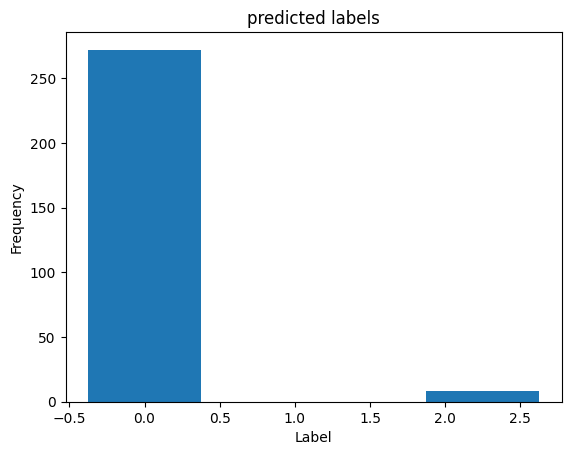

In [8]:
predicted_ds.plot(kind='hist', bins=4, title='predicted labels', xlabel='Label', align='left') # xticks=[x for x in range(21)]

In [8]:
labels_ds.value_counts()

0    96
1    81
2    62
3    41
Name: count, dtype: int64

<Axes: title={'center': 'true labels'}, xlabel='Label', ylabel='Frequency'>

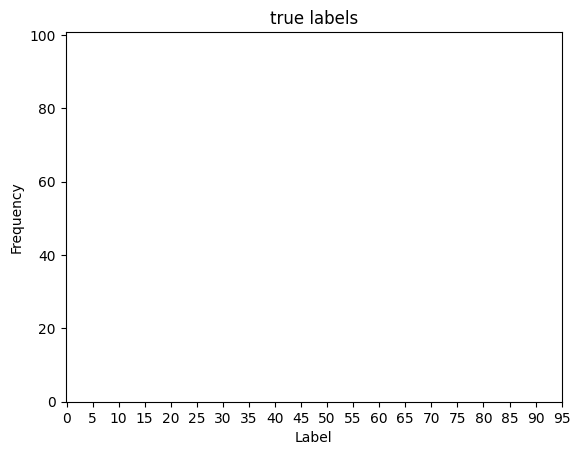

In [9]:
labels_ds.plot(kind='hist', bins=98, title='true labels', xticks=[5*x for x in range(20)], xlabel='Label', align='left')

In [11]:
confusion_mat = confusion_matrix(labels, predicted, labels=[x for x in range(4)], sample_weight=None, normalize=None)

In [12]:
confusion_mat

array([[ 2, 65, 15, 14],
       [ 3, 61,  8,  9],
       [ 0, 24, 34,  4],
       [ 1, 31,  3,  6]], dtype=int64)

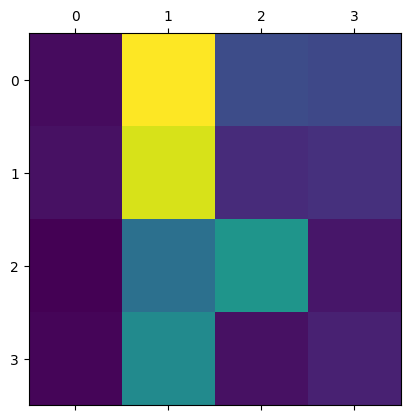

In [13]:
plt.matshow(confusion_mat[0:10, 0:10])

In [2]:
true = torch.randint(low=0, high=10, size=(150,))

In [52]:
pred = torch.randint(low=0, high=10, size=(150,))

In [3]:
true = [1, 2, 1, 1]
pred = [1, 4, 4, 5]

In [24]:
import warnings
import sklearn.exceptions
warnings.filterwarnings(action='ignore')

In [25]:
acc = balanced_accuracy_score(true, pred)
acc

0.16666666666666666

In [73]:
result = []

In [74]:
result = result + true
result

[1, 2, 1, 1]

In [75]:
result = result + pred
result

[1, 2, 1, 1, 1, 4, 4, 5]

In [9]:
path = 'frame_0000000002.jpg'

In [10]:
img = Image.open(path)

In [11]:
arr = np.asarray(img)

In [12]:
arr.shape

(256, 456, 3)

Try multiprocessing

In [2]:
from multiprocessing import Process

In [9]:
lst = []

In [10]:
def load_image(img_path, lst):
    im = Image.open(img_path)
    lst.append(im)
    pass

In [15]:
p = Process(target=load_image, args=[('frame_0000042685.jpg', lst), ('frame_0000042685.jpg', lst)])

In [16]:
p.start()
p.join()

In [17]:
lst

[]

In [8]:
p 

<Process name='Process-1' pid=21376 parent=8876 stopped exitcode=1>